# Part 2: Polynomial Regression and Feature Engineering

**Objective**: Capture nonlinear and interaction effects using polynomial feature engineering and an explicit bias term: $\hat{L} = X \mathbf{w} + b$.

## 1. Dataset and Notation

Feature map $X$ definitions:
*   $M$: stellar mass ($M_\odot$)
*   $T$: effective stellar temperature ($K$)
*   $L$: stellar luminosity ($L_\odot$)

In [10]:
import numpy as np
import matplotlib.pyplot as plt

M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

print(f"Number of training examples: {len(M)}")

Number of training examples: 10


## 2. Dataset Visualization
Task: Plot $L$ vs $M$ and encode $T$.

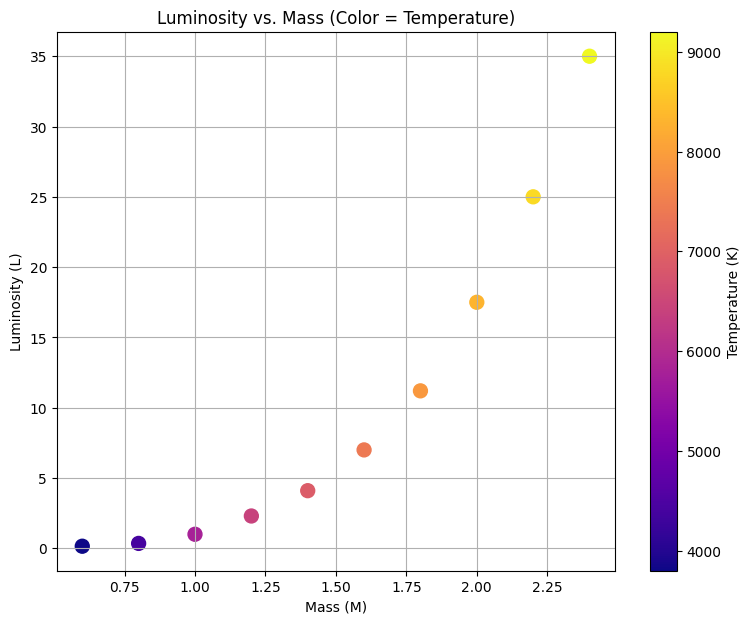

In [11]:
plt.figure(figsize=(9, 7))
scatter = plt.scatter(M, L, c=T, cmap='plasma', s=100, label='Stars')
plt.colorbar(scatter, label='Temperature (K)')
plt.title('Luminosity vs. Mass (Color = Temperature)')
plt.xlabel('Mass (M)')
plt.ylabel('Luminosity (L)')
plt.grid(True)
plt.show()

## 3. Feature Engineering
Construct design matrix $X$ using features: $[M, T, M^2, M \cdot T]$.

In [12]:
def build_features(M, T, mode='M3'):
    """
    - M1: [M, T]
    - M2: [M, T, M^2]
    - M3: [M, T, M^2, M*T]
    """
    M = M.reshape(-1, 1)
    T = T.reshape(-1, 1)
    
    if mode == 'M1':
        return np.hstack((M, T))
    elif mode == 'M2':
        return np.hstack((M, T, M**2))
    elif mode == 'M3':
        MT = (M * T)
        return np.hstack((M, T, M**2, MT))
    else:
        raise ValueError("Unknown mode")
        
def z_score_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    sigma[sigma == 0] = 1
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

## 4. Loss and Gradients (Vectorized)

In [13]:
def predict(X, w, b):
    return np.dot(X, w) + b

def compute_cost(X, y, w, b):
    m = len(y)
    preds = predict(X, w, b)
    cost = (1/(2*m)) * np.sum((preds - y)**2)
    return cost

def compute_gradient(X, y, w, b):
    m = len(y)
    preds = predict(X, w, b)
    err = preds - y
    
    dw = (1/m) * np.dot(X.T, err)
    db = (1/m) * np.sum(err)
    
    return dw, db

In [14]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    w = w_in.copy()
    b = b_in
    J_history = []
    
    for i in range(num_iters):
        dw, db = compute_gradient(X, y, w, b)
        w = w - alpha * dw
        b = b - alpha * db
        J_history.append(compute_cost(X, y, w, b))
        
    return w, b, J_history

## 5. Feature Selection Experiments
Comparisons:
*   M1: $X = [M, T]$
*   M2: $X = [M, T, M^2]$
*   M3: $X = [M, T, M^2, M \cdot T]$

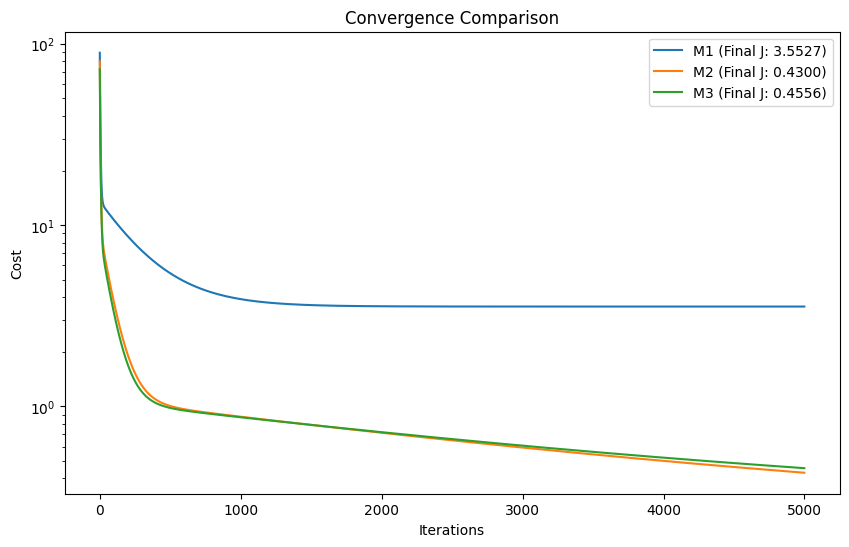

In [15]:
models = ['M1', 'M2', 'M3']
results = {}
scalers = {}

alpha = 0.1
iterations = 5000

plt.figure(figsize=(10, 6))

for name in models:
    X_raw = build_features(M, T, name)
    
    X_norm, mu, sigma = z_score_normalize(X_raw)
    scalers[name] = (mu, sigma)
    
    n_features = X_norm.shape[1]
    w_init = np.zeros(n_features)
    b_init = 0.0
    
    w_final, b_final, J_hist = gradient_descent(X_norm, L, w_init, b_init, alpha, iterations)
    
    results[name] = {
        'w': w_final, 
        'b': b_final, 
        'J_final': J_hist[-1],
        'preds': predict(X_norm, w_final, b_final)
    }
    
    plt.plot(J_hist, label=f"{name} (Final J: {J_hist[-1]:.4f})")
    
plt.title('Convergence Comparison')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.yscale('log')
plt.legend()
plt.show()

### Report and Predictions
Actual vs Predicted plots for each model.

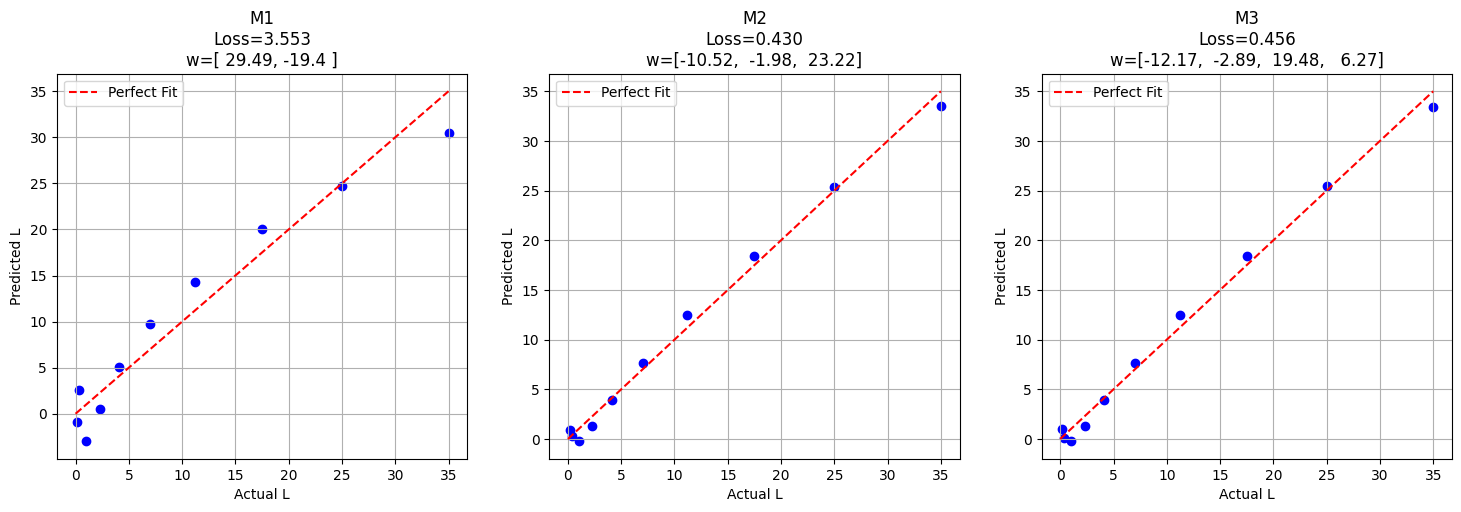

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, name in enumerate(models):
    ax = axes[i]
    preds = results[name]['preds']
    w_disp = np.array2string(results[name]['w'], precision=2, separator=', ')
    
    ax.scatter(L, preds, color='blue')
    ax.plot([0, 35], [0, 35], 'r--', label='Perfect Fit') # Identity line
    ax.set_title(f"{name}\nLoss={results[name]['J_final']:.3f}\nw={w_disp}")
    ax.set_xlabel('Actual L')
    ax.set_ylabel('Predicted L')
    ax.legend()
    ax.grid(True)
    
plt.show()

## 6. Cost vs Interaction Term (M3)

Learned w_MT value: 6.2656


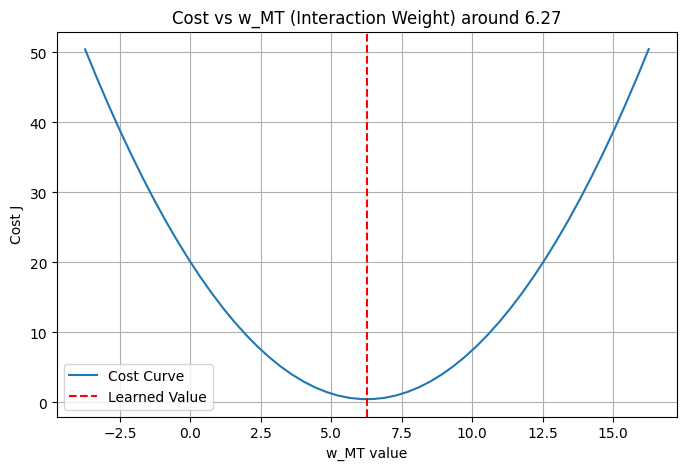

In [17]:
w_m3 = results['M3']['w'].copy()
b_m3 = results['M3']['b']

X_raw_m3 = build_features(M, T, 'M3')
mu_m3, sigma_m3 = scalers['M3']
X_norm_m3 = (X_raw_m3 - mu_m3) / sigma_m3

w_mt_idx = 3
original_val = w_m3[w_mt_idx]
print(f"Learned w_MT value: {original_val:.4f}")

test_values = np.linspace(original_val - 10, original_val + 10, 50)
costs = []

for val in test_values:
    w_temp = w_m3.copy()
    w_temp[w_mt_idx] = val
    c = compute_cost(X_norm_m3, L, w_temp, b_m3)
    costs.append(c)
    
plt.figure(figsize=(8, 5))
plt.plot(test_values, costs, label='Cost Curve')
plt.axvline(original_val, color='r', linestyle='--', label='Learned Value')
plt.title(f'Cost vs w_MT (Interaction Weight) around {original_val:.2f}')
plt.xlabel('w_MT value')
plt.ylabel('Cost J')
plt.legend()
plt.grid(True)
plt.show()

## 7. Inference Demo
Task: Predict luminosity for a new star ($M=1.3, T=6600$) using M3.

In [18]:
M_new = np.array([1.3])
T_new = np.array([6600])

X_new_raw = build_features(M_new, T_new, 'M3')

X_new_norm = (X_new_raw - mu_m3) / sigma_m3

L_pred = predict(X_new_norm, w_m3, b_m3)

print(f"Input: Mass={M_new[0]}, Temp={T_new[0]}")
print(f"Predicted Luminosity: {L_pred[0]:.4f} L_sun")

Input: Mass=1.3, Temp=6600
Predicted Luminosity: 2.4899 L_sun
